# Use of Incomplete Fourier Transform to Fill Gaps in Time Series Data

Bernard J. Rauscher<br>
NASA Goddard Space Fligth Center, Observational Cosmology Laboratory, Greenbelt, MD 20771

28 September 2021

## 1. INTRODUCTION

This document is an executable python-3 Jupyter notebook. Its purpose is to explain the incomplete Fourier transform can be used to fill in gaps in WFI time series read noise data. Gaps can occur for many reasons. Some include planned gaps at the ends of detector rows, known "bad pixels", and cosmic ray hits.

The incomplete Fourier transform (as defined here) uses a subset of all possible Fourier basis vectors to model time series data keeping the most important frequencies. At L2, of order 10% of Roman's pixels will be disturbed by cosmic rays in a typical exposure. For this reason, our model is built by least squares fitting $<90\%$ of all possible Fourier basis vectors to the data.

In practice, we use much less than 90%. From previous work, we know that the lowest and highest approximately 1 kHz tend to be the most imporant frequency ranges. We therefore omit mid-range frequencies from the fit.

This description is intended to be an intuitive introduction for Roman scientists and engineers. The final "proof" that it is sound will be to show by test that Roman Reference Correction works as expected.

## 2. DISCUSSION

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits;

## 2.2 Read in and Plot Sample Data with Gaps

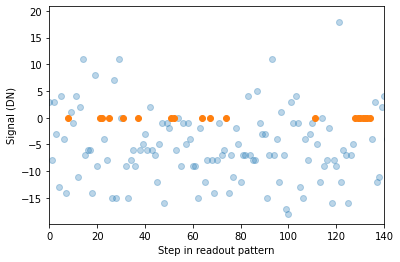

In [2]:
# Import sample data
with fits.open('.irfft_sample_data.fits') as hdul:
    d = hdul[0].data
    
# Reformat as a time series
d = d.flatten()

# Plot. Gaps are set =0.0
x = np.arange(len(d))
plt.plot(x[d!=0.], d[d!=0.], 'o', alpha=.3)
plt.plot(x[d==0.], d[d==0.], 'o', alpha=1.)
plt.xlabel('Step in readout pattern')
plt.ylabel('Signal (DN)')
plt.xlim((0,140));

## 2.2. Use Incomplete Real Fourier Transform to Fill Gaps

Both numpy and Julia's FFTW library use the same Fourier transform,

<center>$Y_k=\sum_{j=0}^{n-1}X_j e^{2\pi j k \sqrt{-1}/n}.\hspace{18pt}k\in\{0,1,\dots n/2\}\hspace{18pt}(1)$</center>

Here $n$ is the number of time steps in the clocking pattern. By inspection, the basis vectors are,

<center>$\mathbf{B}_k^j=e^{2\pi j k \sqrt{-1}/n}.\hspace{18pt}(2)$</center>

In Eq. 2, the subscript $k$ is covariant. It identifies the column in the matrix $\mathbf{B}$. The index $j$ is contravariant. By convention, it identifies with the row index in the matrix. Our Incomplete Real Fourier Transform gives the best least squares projection of $\mathbf{B}$ onto the data, $\mathbf{d}$,

<center>$\mathscr{d} = \mathbf{B}^+ \mathbf{d},\hspace{18pt}(3)$</center>

where "$^+$" denotes the Moore-Penrose inverse.

In order for the least squares solution of Eq. 3 to exist, we require that the matrix $\mathbf{B}$ have fewer colunns than the vector $\mathbf{d}$ has rows. From previous work with Roman detectors, we know that the most important frequences are the lowest and highest 1 kHz.

In [3]:
n = len(d)
𝒇 = np.fft.rfftfreq(len(d), d=5.e-6) # Fourier frequencies

By inspection, these are about the lowest and highest 8 frequencies. We must compute he values of these vectors at all the "good" data points. By inspection, the amplitude is close to zero at other frequencies.

In [4]:
n_keep = 8                   # Keep this many frequencies at each end
p_gd = d != 0.               # Good samples
p_bd = np.logical_not(p_gd)  # Bad samples

# Create vectors of j and k values for Eq. 2
j = np.arange(n)[p_gd]                         # J values for all the good samples
k = np.arange(n//2+1)                          # All frequencies
k = np.concatenate((k[:n_keep],k[-n_keep:]))   # Only those for the lowest and highest

# An empty B matrix
B = np.empty((np.sum(p_gd),2*n_keep), dtype=np.complex64)

# Fill in B
for _j in np.arange(len(j)):
    for _k in np.arange(len(k)):
        B[_j,_k] = np.exp(2*np.pi*j[_j]*k[_k]*1J/n)
        
# Compute its Moore-Penrose inverse
pinvB = np.linalg.pinv(B)

As a sanity check, the rows of pinvB should look like sines and cosines except for when 𝒇 = 0 Hz. There will be some imperfections on account of the gaps. Plot a few.

The sine and cosine behavior will be easy to see at low frequency. At high frequency, it is harder to pick out because the wavelength is comparable to the time spacing.

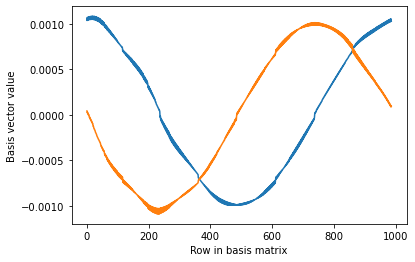

In [5]:
r = 1 # Plot this row
plt.plot(np.real(pinvB[r]), '-')
plt.plot(np.imag(pinvB[r]), '-')
plt.xlabel('Row in basis matrix')
plt.ylabel('Basis vector value');

Compute the Incomplete Real Fourier Transform of our data.

In [6]:
irft_d = np.matmul(pinvB, d[p_gd])

To model the data, 

In [7]:
rfft = np.zeros((n//2+1), dtype=np.complex64)
rfft[:n_keep]  = irft_d[:n_keep]
rfft[-n_keep:] = irft_d[-n_keep:]

In [8]:
dd = n * np.fft.irfft(rfft) # See numpy documentation for normalization

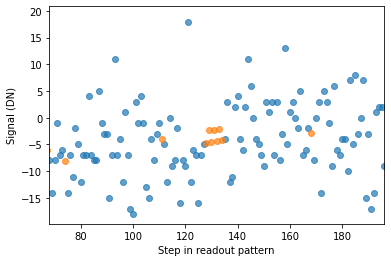

In [9]:
plt.plot(x[p_gd], d[p_gd], 'o', alpha=.7)
plt.plot(x[p_bd], dd[p_bd], 'o', alpha=.7)
plt.xlim(132-64, 132+64)
plt.xlabel('Step in readout pattern')
plt.ylabel('Signal (DN)');

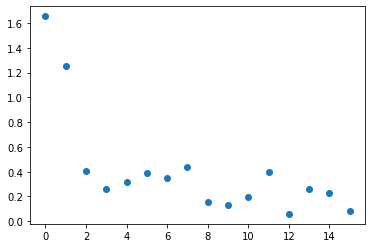

In [10]:
plt.plot(np.abs(irft_d), 'o')